<a href="https://colab.research.google.com/github/MarkusNeusinger/defichain-data-toolkit/blob/main/notebooks/daily_dfi_burn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily DFI Burn, 7 day moving avg

In [ ]:
# imports
import pandas as pd
from urllib.parse import urlencode
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from urllib.parse import urlencode
from concurrent.futures import ThreadPoolExecutor


def fetch_history(history_type, features, from_timestamp=None, to_timestamp=None, retries=3, max_worker=8):
    base_url = f'https://api.defichain-data.com/v0/history_{history_type}'
    all_feature_dfs = []

    def fetch_single_feature(feature):
        for _ in range(retries):
            try:
                parameters = {
                    'features': feature,
                    'format': 'csv'
                }
                if from_timestamp:
                    parameters['from_timestamp'] = from_timestamp
                if to_timestamp:
                    parameters['to_timestamp'] = to_timestamp

                history_url = f"{base_url}?{urlencode(parameters)}"
                feature_df = pd.read_csv(history_url)

                # Check if the DataFrame has any rows
                if feature_df.shape[0] == 0 or feature_df.shape[1] != 2:
                    raise ValueError("DataFrame is empty or has wrong number of columns")

                if 'datetime_utc' in feature_df.columns:
                    feature_df['datetime_utc'] = pd.to_datetime(feature_df['datetime_utc'])
                    all_feature_dfs.append(feature_df)
                return feature_df
            except Exception as e:
                print(f"Failed to fetch data for {feature} - retrying. Error: {e}")

        print(f"Failed to fetch data for {feature} after {retries} retries")
        return None

    with ThreadPoolExecutor(max_workers=max_worker) as executor:
        list(tqdm(executor.map(fetch_single_feature, features), total=len(features)))

    # Merge all feature DataFrames
    if all_feature_dfs:
        history_df = pd.concat(all_feature_dfs, axis=0)
        history_df = history_df.groupby('datetime_utc', as_index=False).first()
        history_df = history_df.sort_values('datetime_utc', ascending=False)
        return history_df
    else:
        return None

In [ ]:
df = fetch_data('daily', ['Height', 'EmissionTotal', 'BurnedTotal'], from_timestamp='2023-06-01')
df.sort_values('datetime_utc', ascending=True, inplace=True)
df.head()

100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


,datetime_utc,burnedtotal,emissiontotal,height
0,2023-06-01,3.176424e+08,141.272362,2.982155e+06
1,2023-06-02,3.176433e+08,141.016392,2.985067e+06
2,2023-06-03,3.176434e+08,138.930066,2.987942e+06
3,2023-06-04,3.176434e+08,138.930066,2.990796e+06
4,2023-06-05,3.176435e+08,138.930066,2.993661e+06


In [ ]:
# calculate 1day diff
df['time_diff'] = df['datetime_utc'].diff().dt.total_seconds()
df['height_diff'] = df['height'].diff()
df['burn_diff'] = df['burnedtotal'].diff()

# drop rows with diff > 1day or nan
df = df[df['time_diff'] == 86400].copy()
df['emission'] = df['emissiontotal'] * df['height_diff']
df['burn'] = df['burn_diff']

# calculate 7 day moving avg of burn
df['burn_7day_avg'] = df['burn'].rolling(window=7).mean()

df.head()

,datetime_utc,burnedtotal,emissiontotal,height,time_diff,height_diff,burn_diff,emission,burn,burn_7day_avg
1,2023-06-02,3.176433e+08,141.016392,2.985067e+06,86400.0,2912.697368,958.156355,410738.074966,958.156355,NaN
2,2023-06-03,3.176434e+08,138.930066,2.987942e+06,86400.0,2874.517996,53.233346,399356.975147,53.233346,NaN
3,2023-06-04,3.176434e+08,138.930066,2.990796e+06,86400.0,2854.178490,40.038776,396531.206243,40.038776,NaN
4,2023-06-05,3.176435e+08,138.930066,2.993661e+06,86400.0,2864.791911,21.552386,398005.729578,21.552386,NaN
5,2023-06-06,3.176435e+08,138.930066,2.996486e+06,86400.0,2825.049285,88.088401,392484.283796,88.088401,NaN


Text(0.5, 1.0, 'df burn/day')

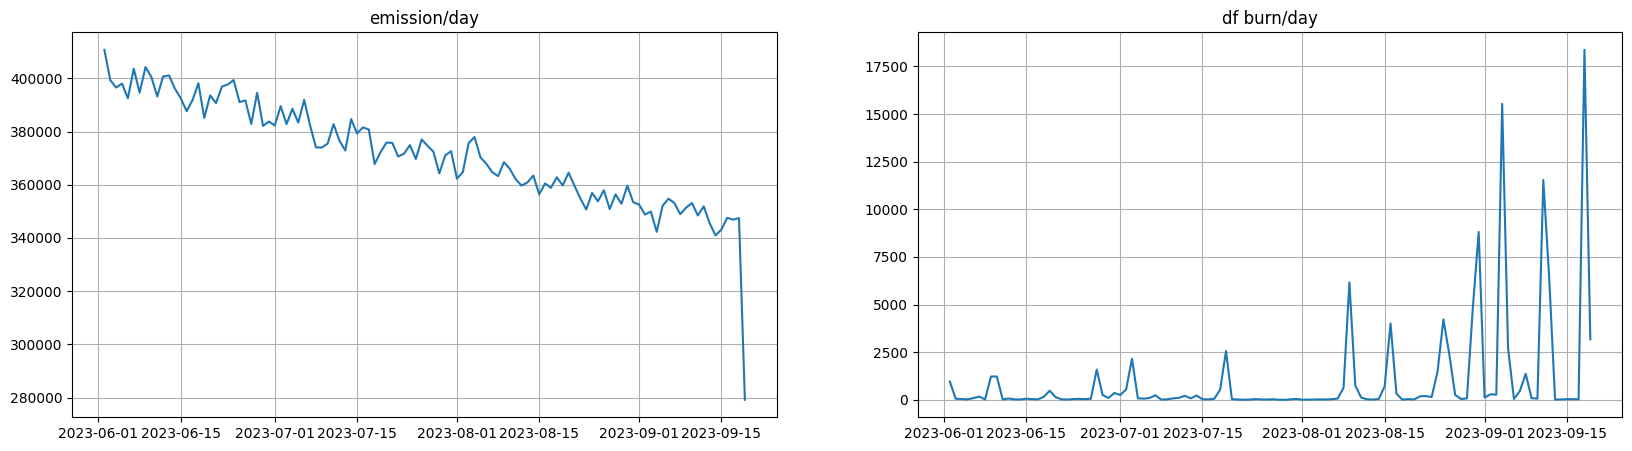

In [ ]:
# plot emission/burn
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axs[0].plot(df['datetime_utc'], df['emission'])
axs[0].grid()
axs[0].set_title('emission/day')

axs[1].plot(df['datetime_utc'], df['burn'])
axs[1].grid()
axs[1].set_title('df burn/day')

Text(0, 0.5, 'DFI burn / day')

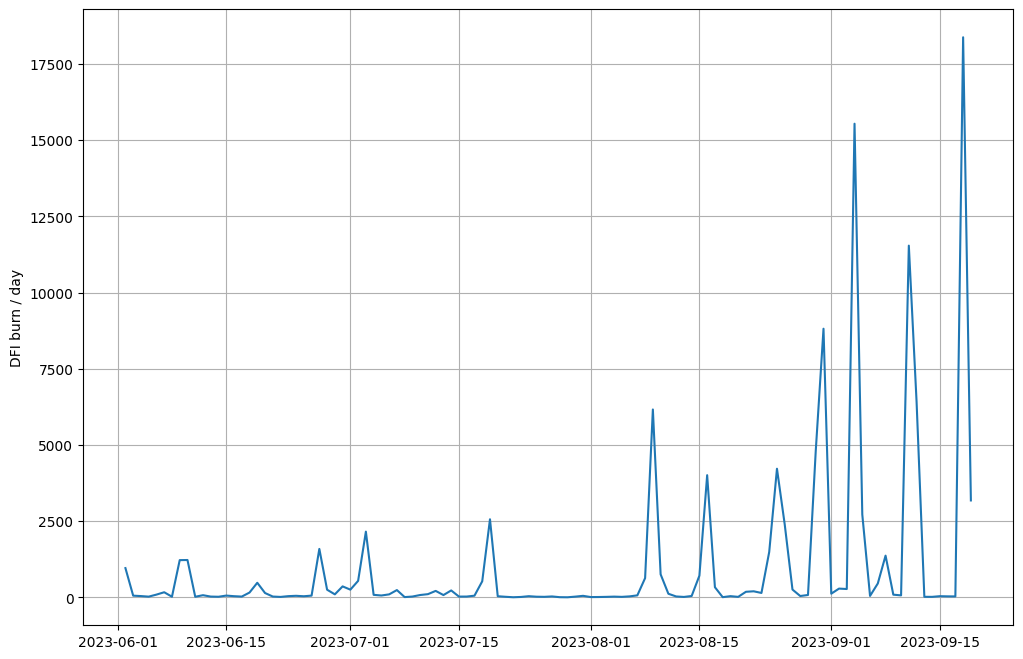

In [ ]:
# plot burn
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

axs.plot(df['datetime_utc'], df['burn'])
axs.grid()
axs.set_ylabel('DFI burn / day')

Text(0, 0.5, 'DFI burn / day (7day avg)')

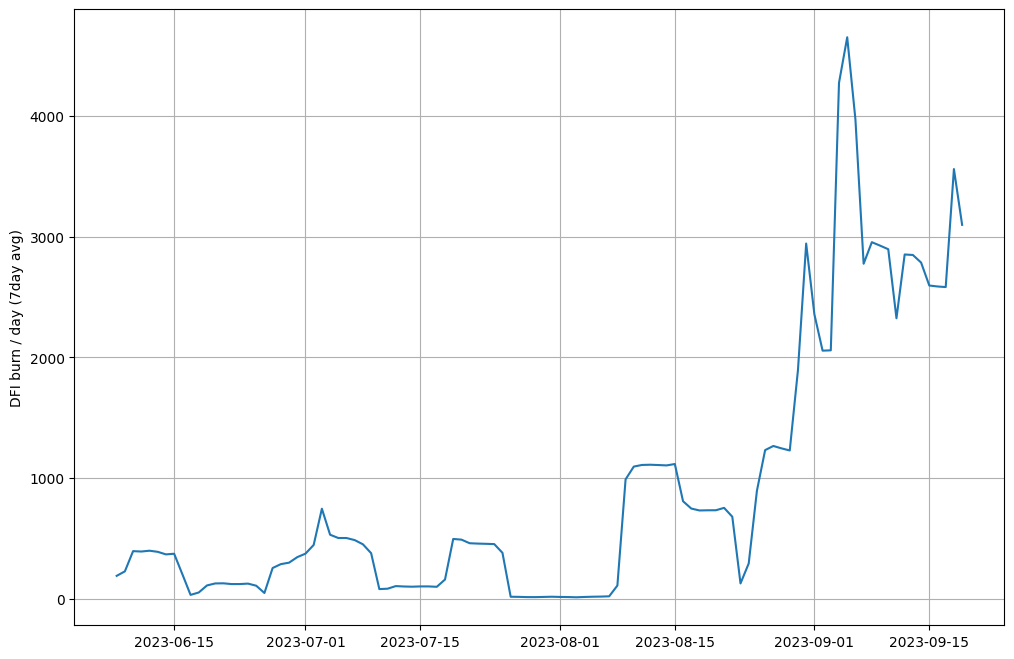

In [ ]:
# plot burn
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

axs.plot(df['datetime_utc'], df['burn_7day_avg'])
axs.grid()
axs.set_ylabel('DFI burn / day (7day avg)')

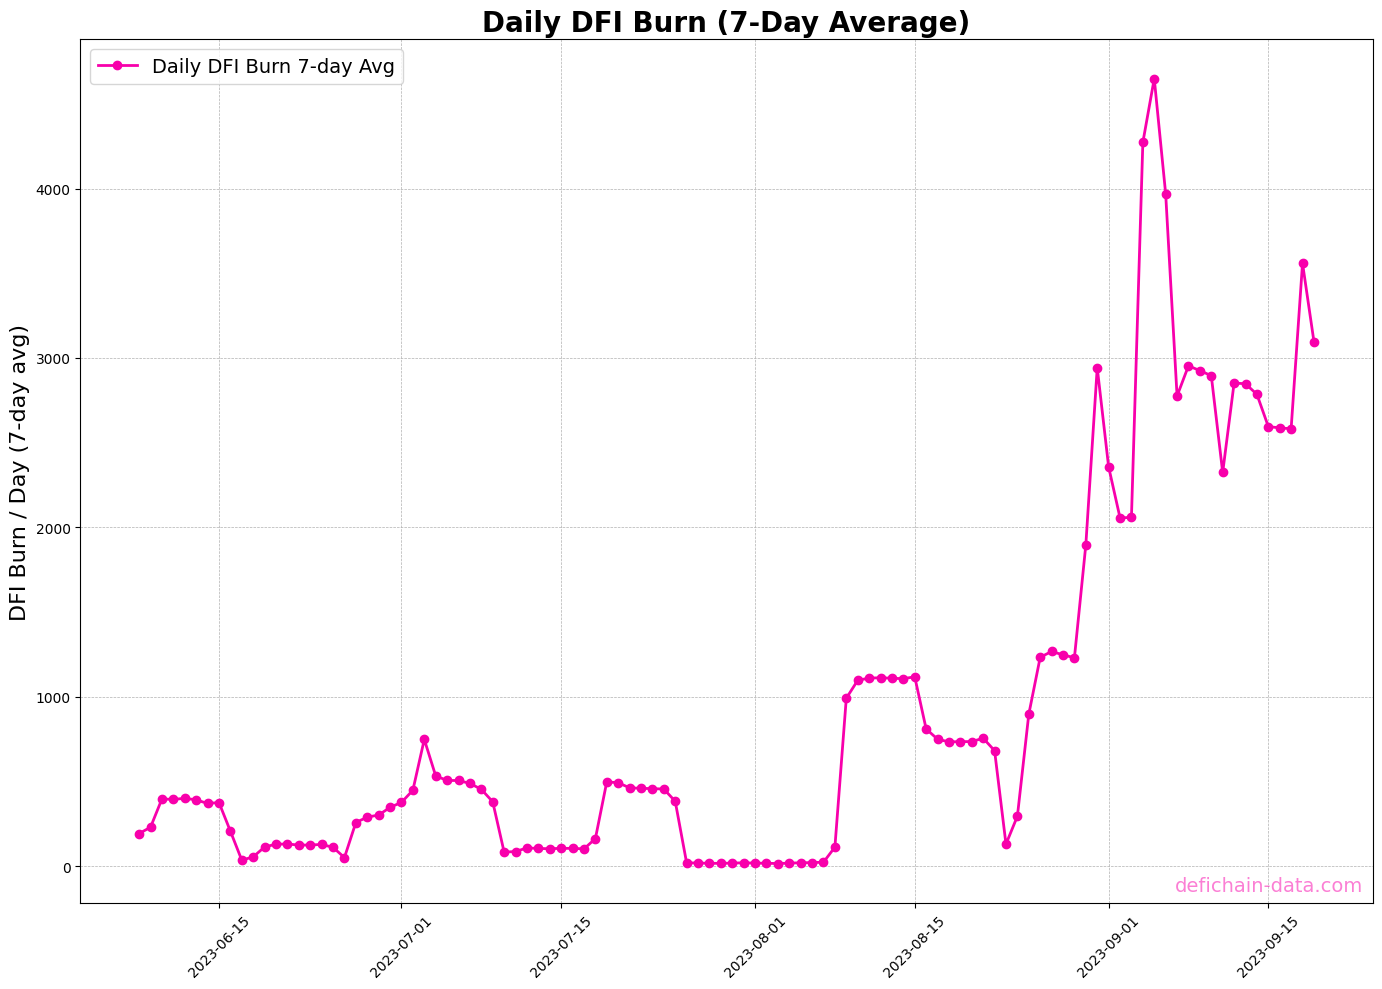

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))

# Plot the 7-day average burn
axs.plot(df['datetime_utc'], df['burn_7day_avg'], marker='o', linestyle='-', linewidth=2, markersize=6, color='#F800AB', label='Daily DFI Burn 7-day Avg')

# Add title and labels
axs.set_title('Daily DFI Burn (7-Day Average)', fontsize=20, fontweight='bold')
axs.set_xlabel(None, fontsize=16)
axs.set_ylabel('DFI Burn / Day (7-day avg)', fontsize=16)

# Customize grid and ticks
axs.grid(which='both', linestyle='--', linewidth=0.5)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend
axs.legend(fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add watermark
axs.text(0.92, 0.02, 'defichain-data.com', ha='center', va='center', transform=axs.transAxes, fontsize=14, color='#F800AB', alpha=0.5)

# Show the plot
plt.tight_layout()

plt.savefig('Daily_DFI_Burn.png', dpi=300)

plt.show()
